# Decoding trajectories back to gene space

Prerequisites:
- You have trained your MIOFlow model and obtained trajectories [notebook: 6-mioflow]: 
    - trajectoreis:
    - else: 
    
- You have trained and saved a Dimension Changer Encoder/Decoder [notebook: 4-dimension-changer]:
    - saved under the `DIMENSION_CHANGER_DIR = '../../dimension_changer'`


In this notebook, we will:
- Run MIOFlow on our PHATE space to infer trajectories

# TODO: BETTER DESCRIPTION OF THIS NOTEBOOK

In [55]:
import scanpy as sc
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

PROCESSED_DATA_DIR = os.path.join('../../data', 'processed')
DIMENSION_CHANGER_DIR = os.path.join('../../dimension_changer')
RESULTS_DIR = os.path.join('../../results')

data_name = 'adata'
SAVE_PATH = os.path.join(RESULTS_DIR, data_name)

adata = sc.read(os.path.join(PROCESSED_DATA_DIR, 'adata_mioflow.h5ad'))
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'smooth_time', 'bin_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_visualization'
    varm: 'PCs'

In [56]:
gene_names = adata.var_names

traj = np.load(os.path.join(SAVE_PATH,'trajectories_phate.npy'))


In [57]:
from omics_toolbox.dimchanger import DimChanger

dimchanger = DimChanger.load(DIMENSION_CHANGER_DIR)

In [58]:
X_phate = adata.obsm['X_phate']
X_pca = adata.obsm['X_pca']
X_phate_vis = adata.obsm['X_phate_visualization']
var_ratio = adata.uns['pca']['variance_ratio']

In [59]:
traj_shapes = traj.shape
traj_flat = traj.reshape(-1, traj.shape[-1])
traj_pca = dimchanger.phate2pca(traj_flat)
traj_vis = dimchanger.phate2vis(traj_flat)
traj_pca = traj_pca.reshape(traj_shapes[0], traj_shapes[1], -1)
traj_vis = traj_vis.reshape(traj_shapes[0], traj_shapes[1], -1)

In [60]:
traj_pca.shape

(100, 100, 50)

Text(0.5, 1.0, 'Decoded trajectories in PCA space')

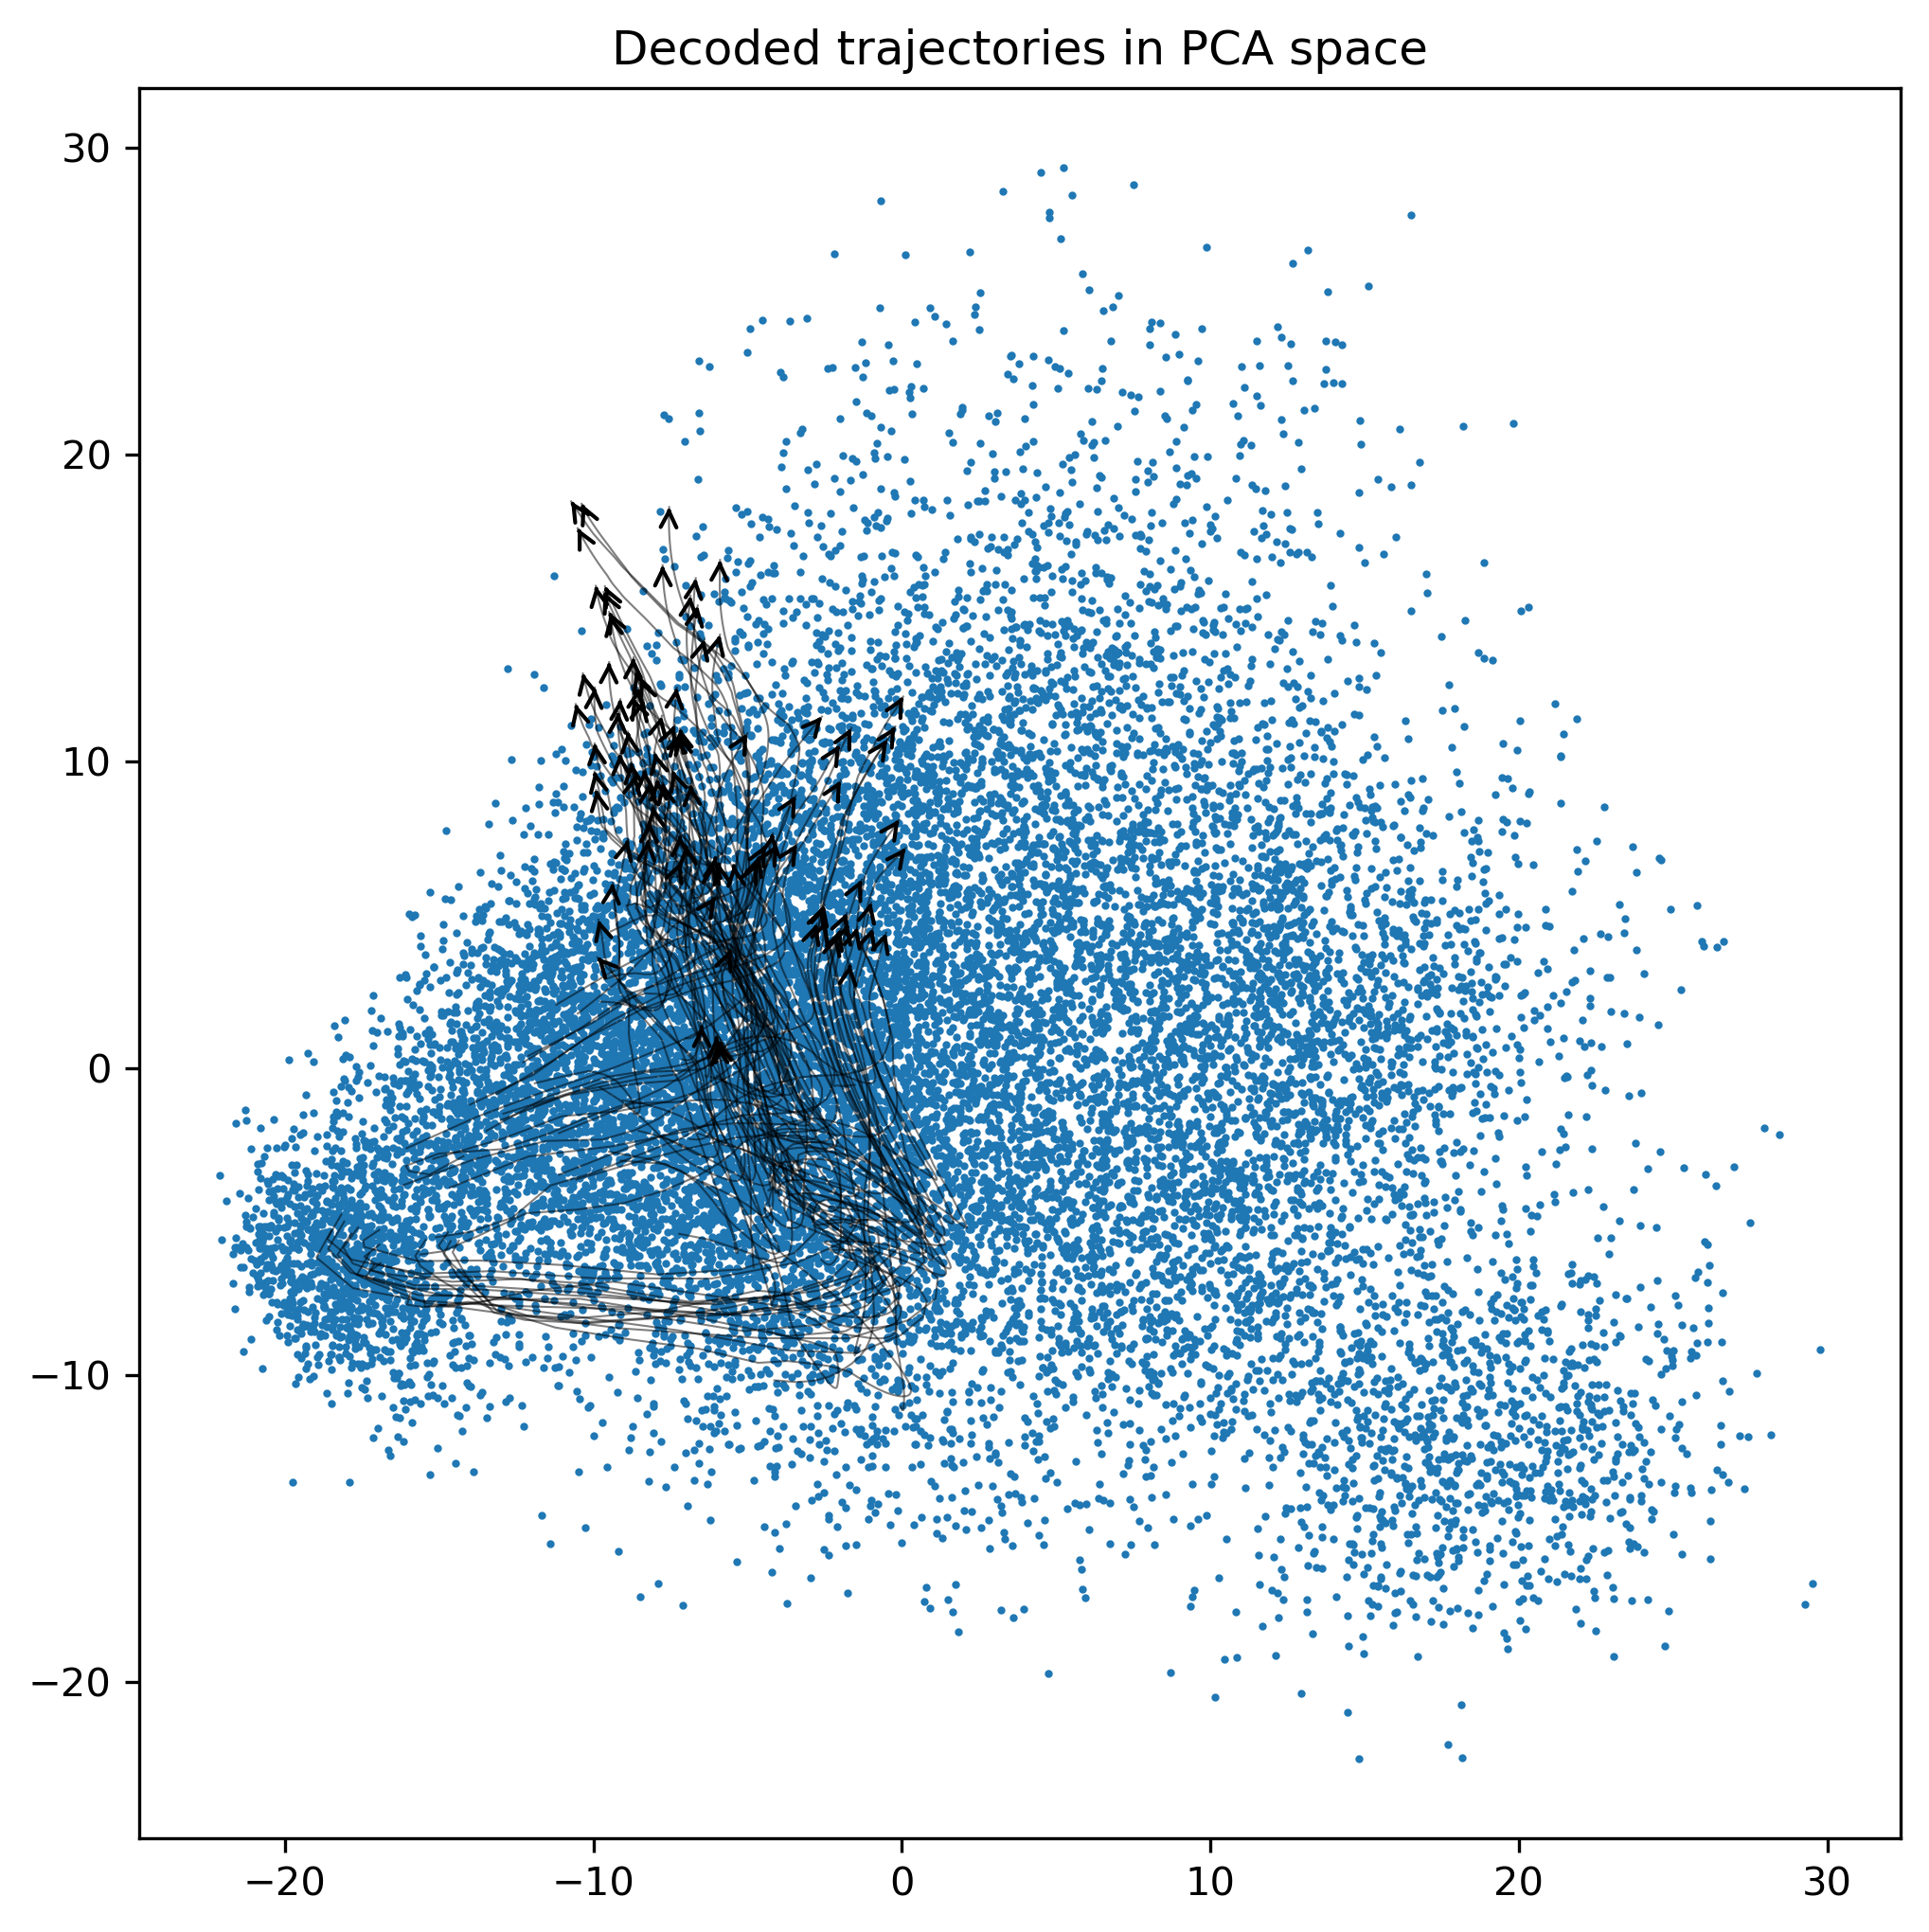

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)
# subsample_ids = np.random.choice(np.arange(traj_pca.shape[0]), size=10, replace=False)
for i,traji in enumerate(np.transpose(traj_pca, axes=(1,0,2))):
    plt.plot(traji[:, 0], traji[:, 1], alpha=.5, linewidth=.5, c='Black')
    plt.annotate('', xy=(traji[-1, 0], traji[-1, 1]), xytext=(traji[-2, 0], traji[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color='Black', lw=1, mutation_scale=10))
plt.title("Decoded trajectories in PCA space")


/var/folders/1r/l8_zwkvx7_g7b632hf_1517c0000gn/T/ipykernel_17749/991043374.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_phate_vis[:, 0], X_phate_vis[:, 1], cmap='viridis', s=1)


Text(0.5, 1.0, 'Mapped trajectories in 2D PHATE space')

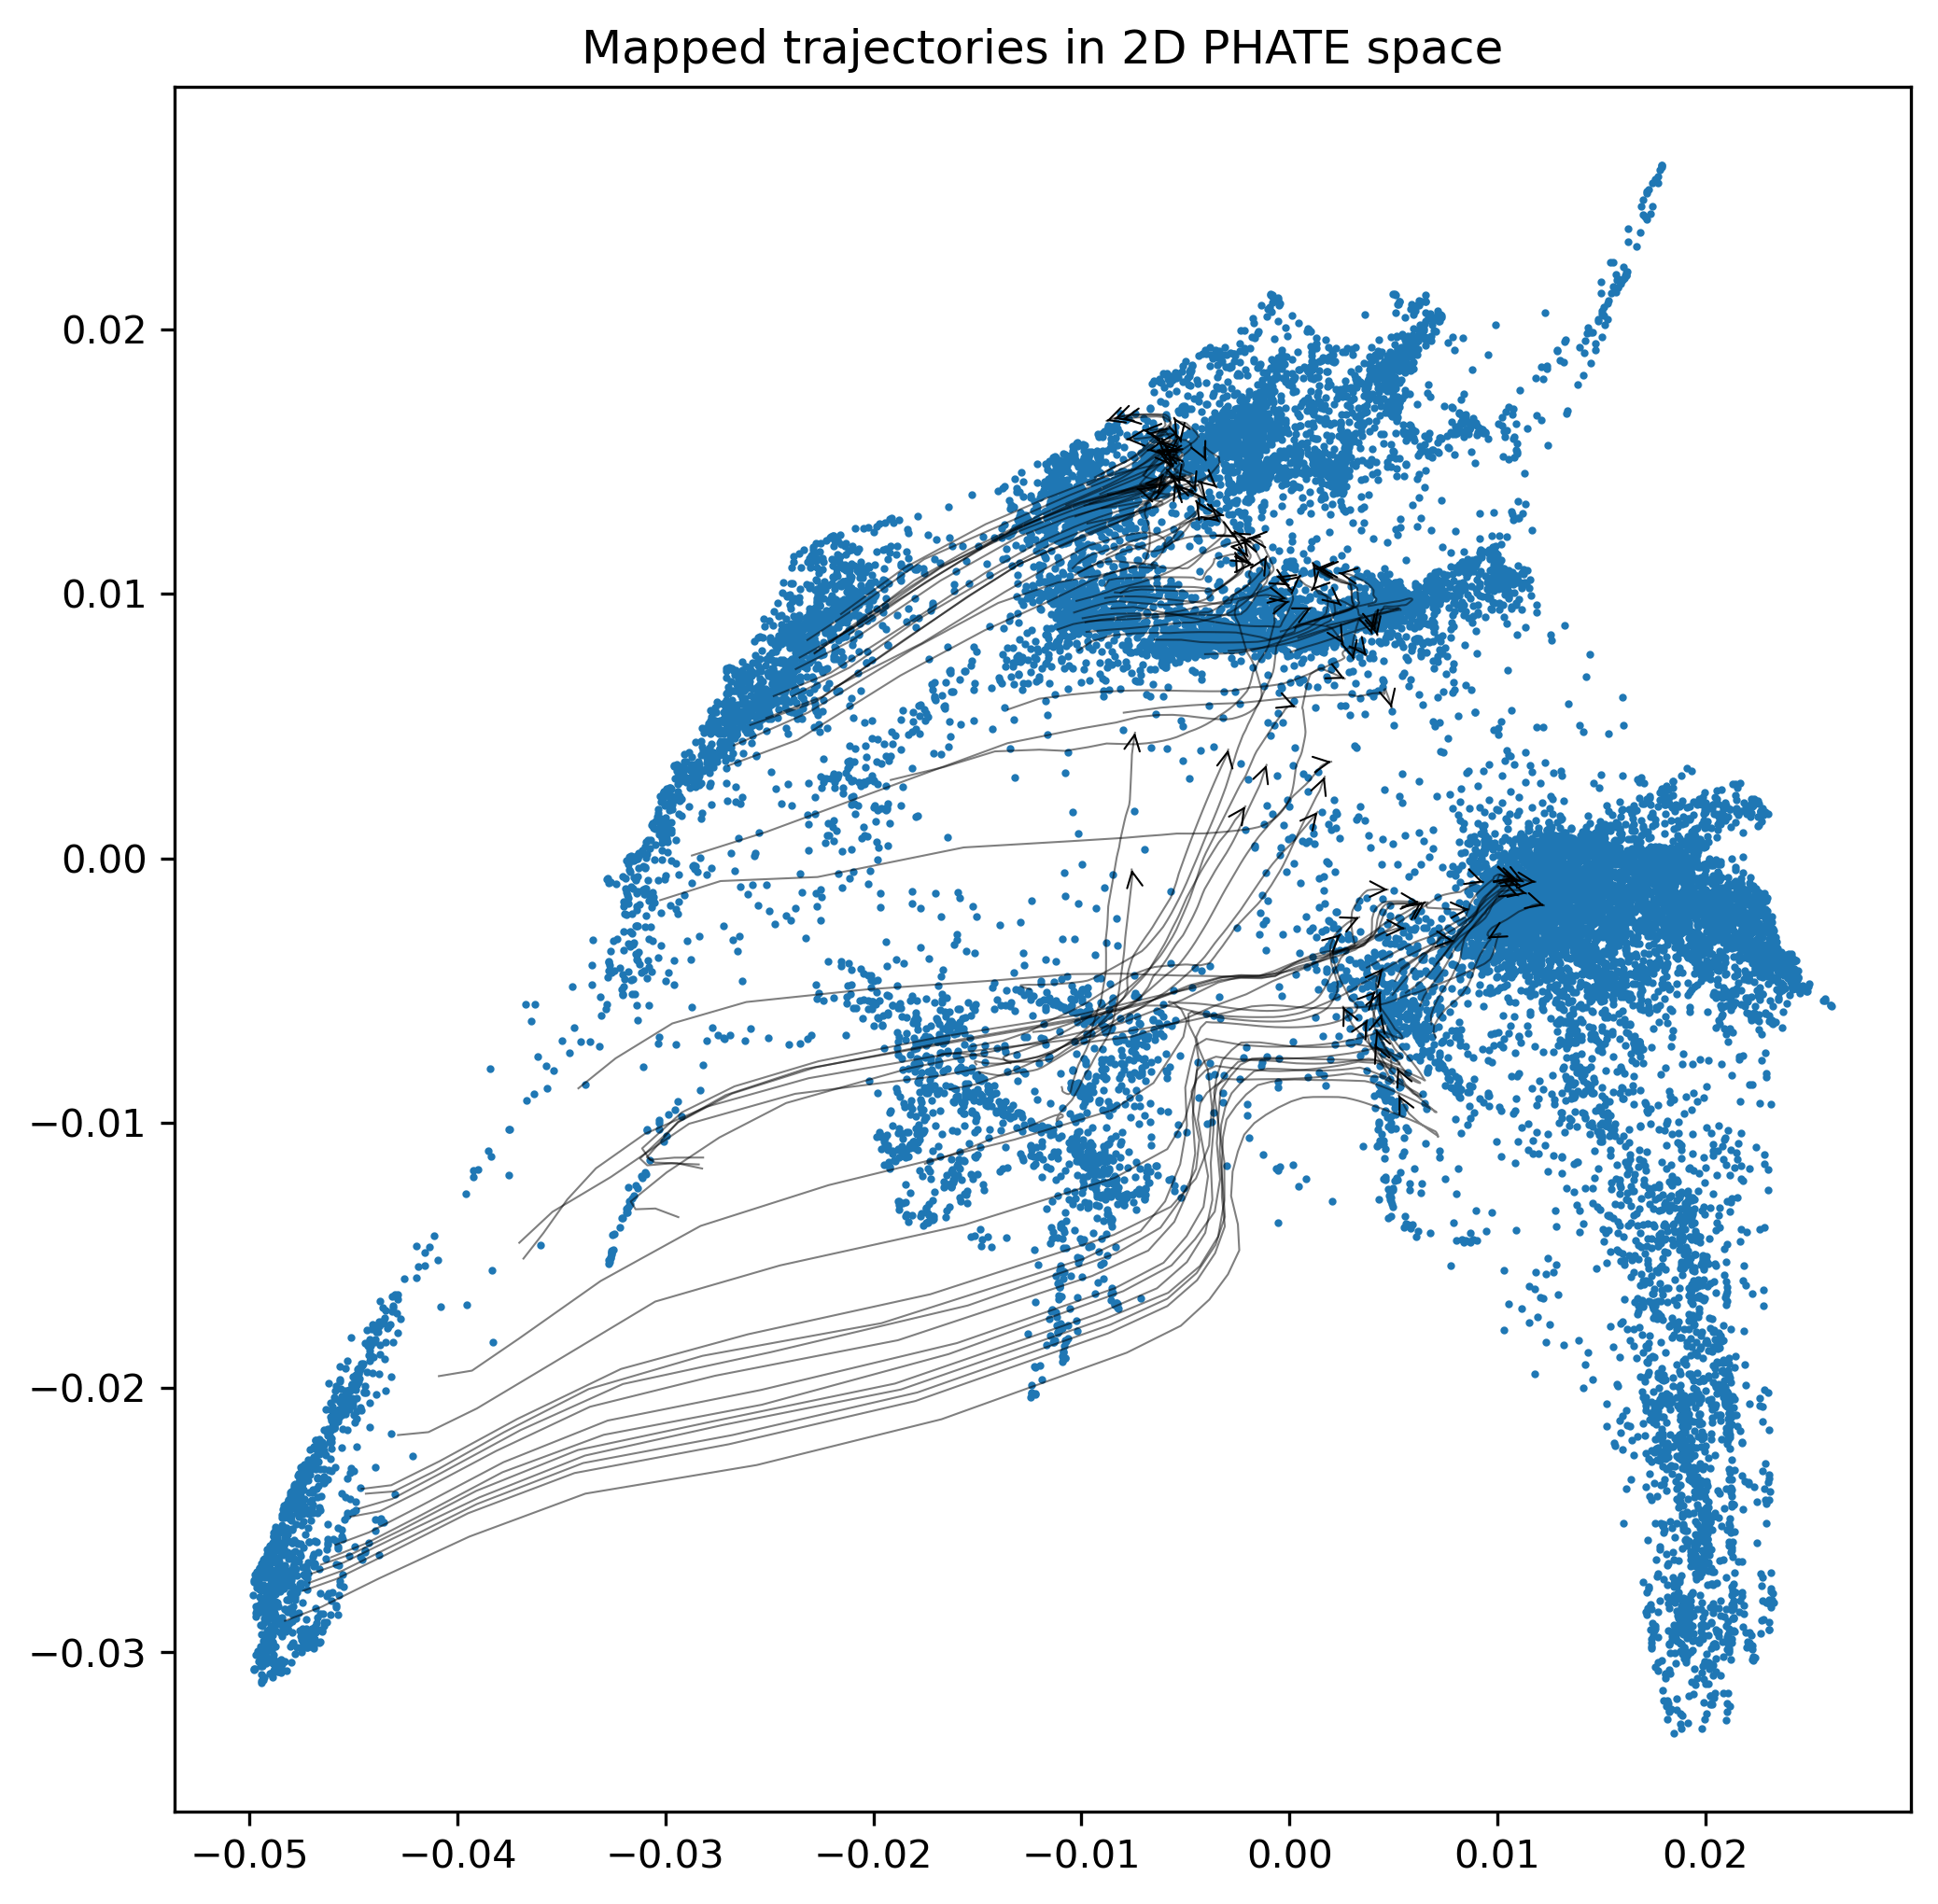

In [62]:
fig = plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(X_phate_vis[:, 0], X_phate_vis[:, 1], cmap='viridis', s=1)
for i,traji in enumerate(np.transpose(traj_vis, axes=(1,0,2))):
# for i,traj in enumerate(trajvis):
    plt.plot(traji[:, 0], traji[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traji[-1, 0], traji[-1, 1]), xytext=(traji[-2, 0], traji[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color='Black', lw=.5, mutation_scale=10))
plt.title("Mapped trajectories in 2D PHATE space")
# plt.scatter(trajendvis[:, 0], trajendvis[:, 1], c='Red', s=10)
# plt.scatter(trajend[:, 0], trajend[:, 1], c='Blue', s=10)
# plt.plot(unatraj[:, 0], unatraj[:, 1], c='Green', linewidth=1)
# plt.plot(unatrajvis[:, 0], unatrajvis[:, 1], c='Orange', linewidth=1)

In [63]:
traj_dec_np = traj_pca.reshape(-1, traj_pca.shape[-1])
X_recon = np.array((traj_dec_np @ adata.varm['PCs'].T) + adata.X.mean(axis=0))


In [64]:
traj_gene_sp = X_recon.reshape(traj.shape[0], traj.shape[1], -1)

In [65]:
traj_gene_sp.shape

(100, 100, 18019)

In [66]:
np.save(os.path.join(SAVE_PATH,'traj_gene_sp.npy'), traj_gene_sp)

# Observing the decoded genes

In [83]:
sc.pp.highly_variable_genes(adata, n_top_genes=25)
example_gene = adata.var_names[adata.var['highly_variable']]

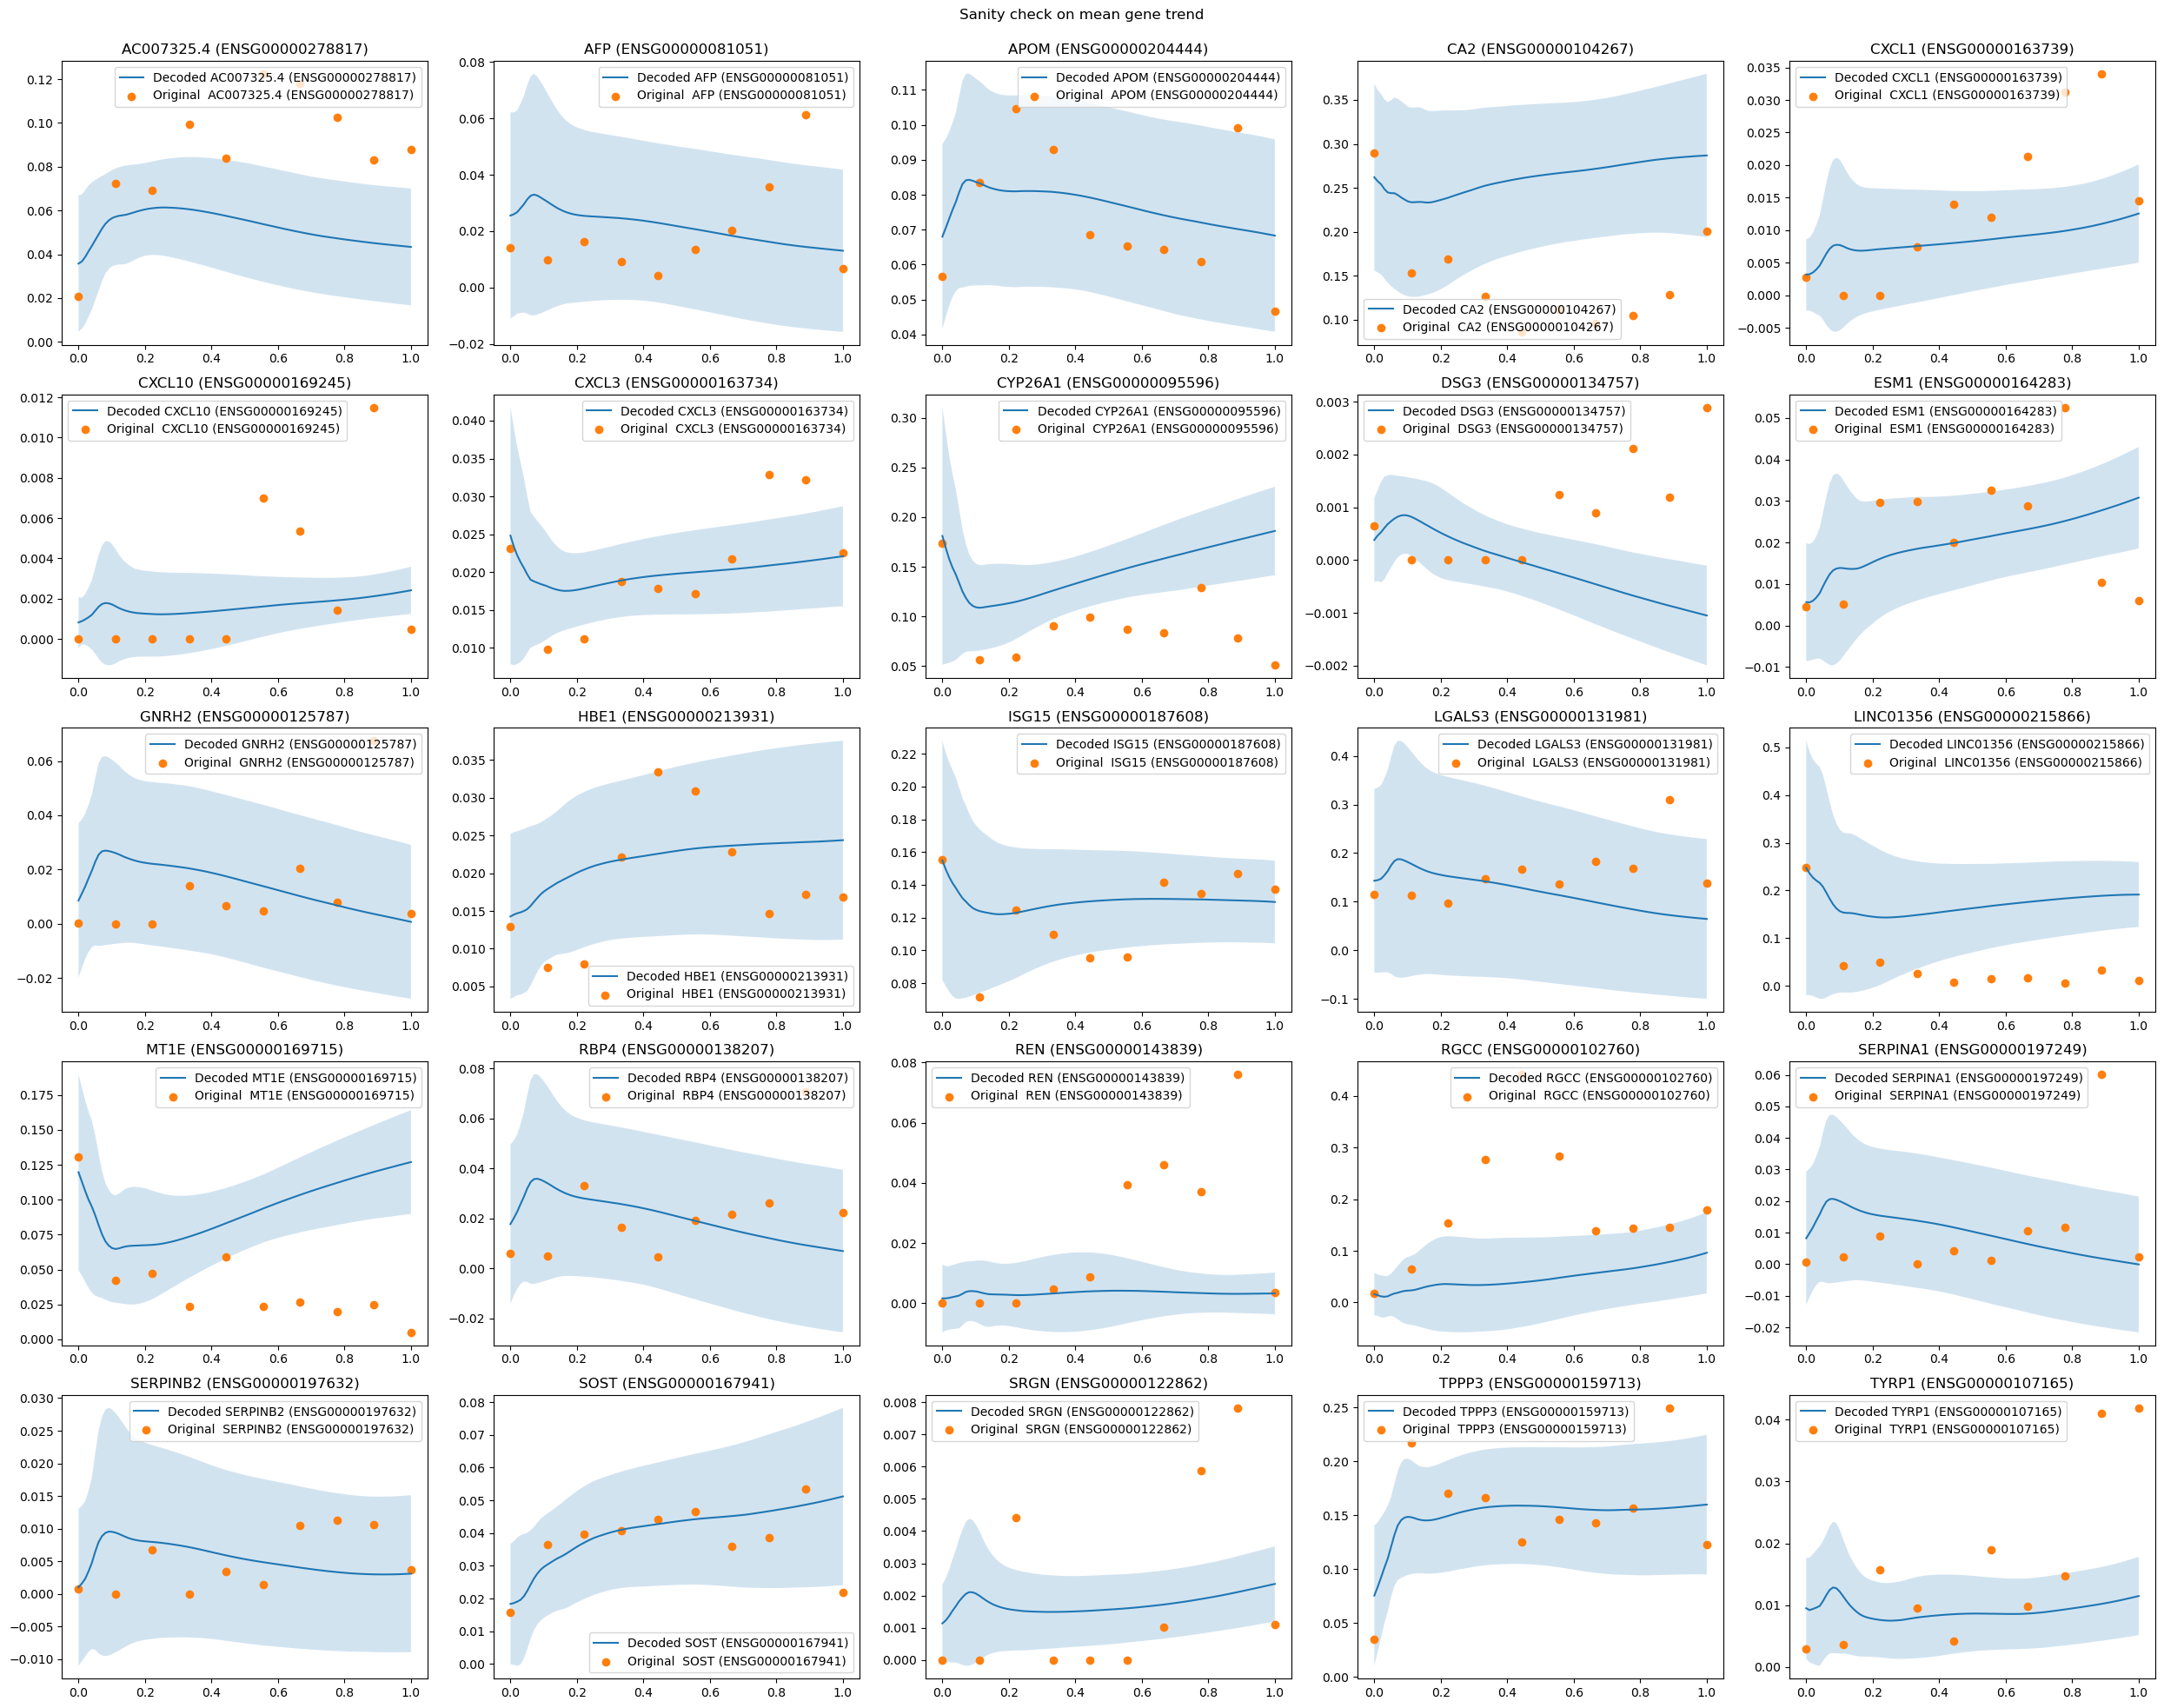

In [86]:
example_gene = [g for g in example_gene if g in adata.var_names]
example_gene_mask = adata.var_names.isin(example_gene)

adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = traj_gene_sp[:, :, example_gene_mask]
decoded_example_gene_mean = decoded_example_gene.mean(axis=1)
decoded_example_gene_std = decoded_example_gene.std(axis=1)
x_time = np.linspace(0, 1, traj.shape[1])
x_time_data = adata_example_gene.obs['bin_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

data_df = pd.DataFrame(adata_example_gene.X.toarray(), columns=example_gene, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data

data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

n_genes = decoded_example_gene_mean.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_example_gene_mean[:,i], label=f'Decoded {example_gene[i].split("_Cycle")[-1]}')
    ax.fill_between(x_time, decoded_example_gene_mean[:,i] - decoded_example_gene_std[:,i], decoded_example_gene_mean[:,i] + decoded_example_gene_std[:,i], alpha=0.2)
    ax.scatter(data_mean.index, data_mean[example_gene[i]], label=f'Original  {example_gene[i].split("_Cycle")[-1]}')
    # ax.fill_between(data_mean.index, data_mean[example_gene[i]] - data_std[example_gene[i]], data_mean[example_gene[i]] + data_std[example_gene[i]], alpha=0.2)
    ax.legend()
    ax.set_title(example_gene[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
# Add suptitle with padding
plt.subplots_adjust(top=0.95)  # Leave space at top
plt.suptitle('Sanity check on mean gene trend', y=0.98)  # Position suptitle in the space

plt.show()

In [103]:
adata.varm['PCs'].T.shape

(50, 18019)

In [104]:
adata.X.mean(axis=0).shape

(1, 18019)

In [87]:
X_pca_dec_back = (X_pca @ adata.varm['PCs'].T) + adata.X.mean(axis=0)

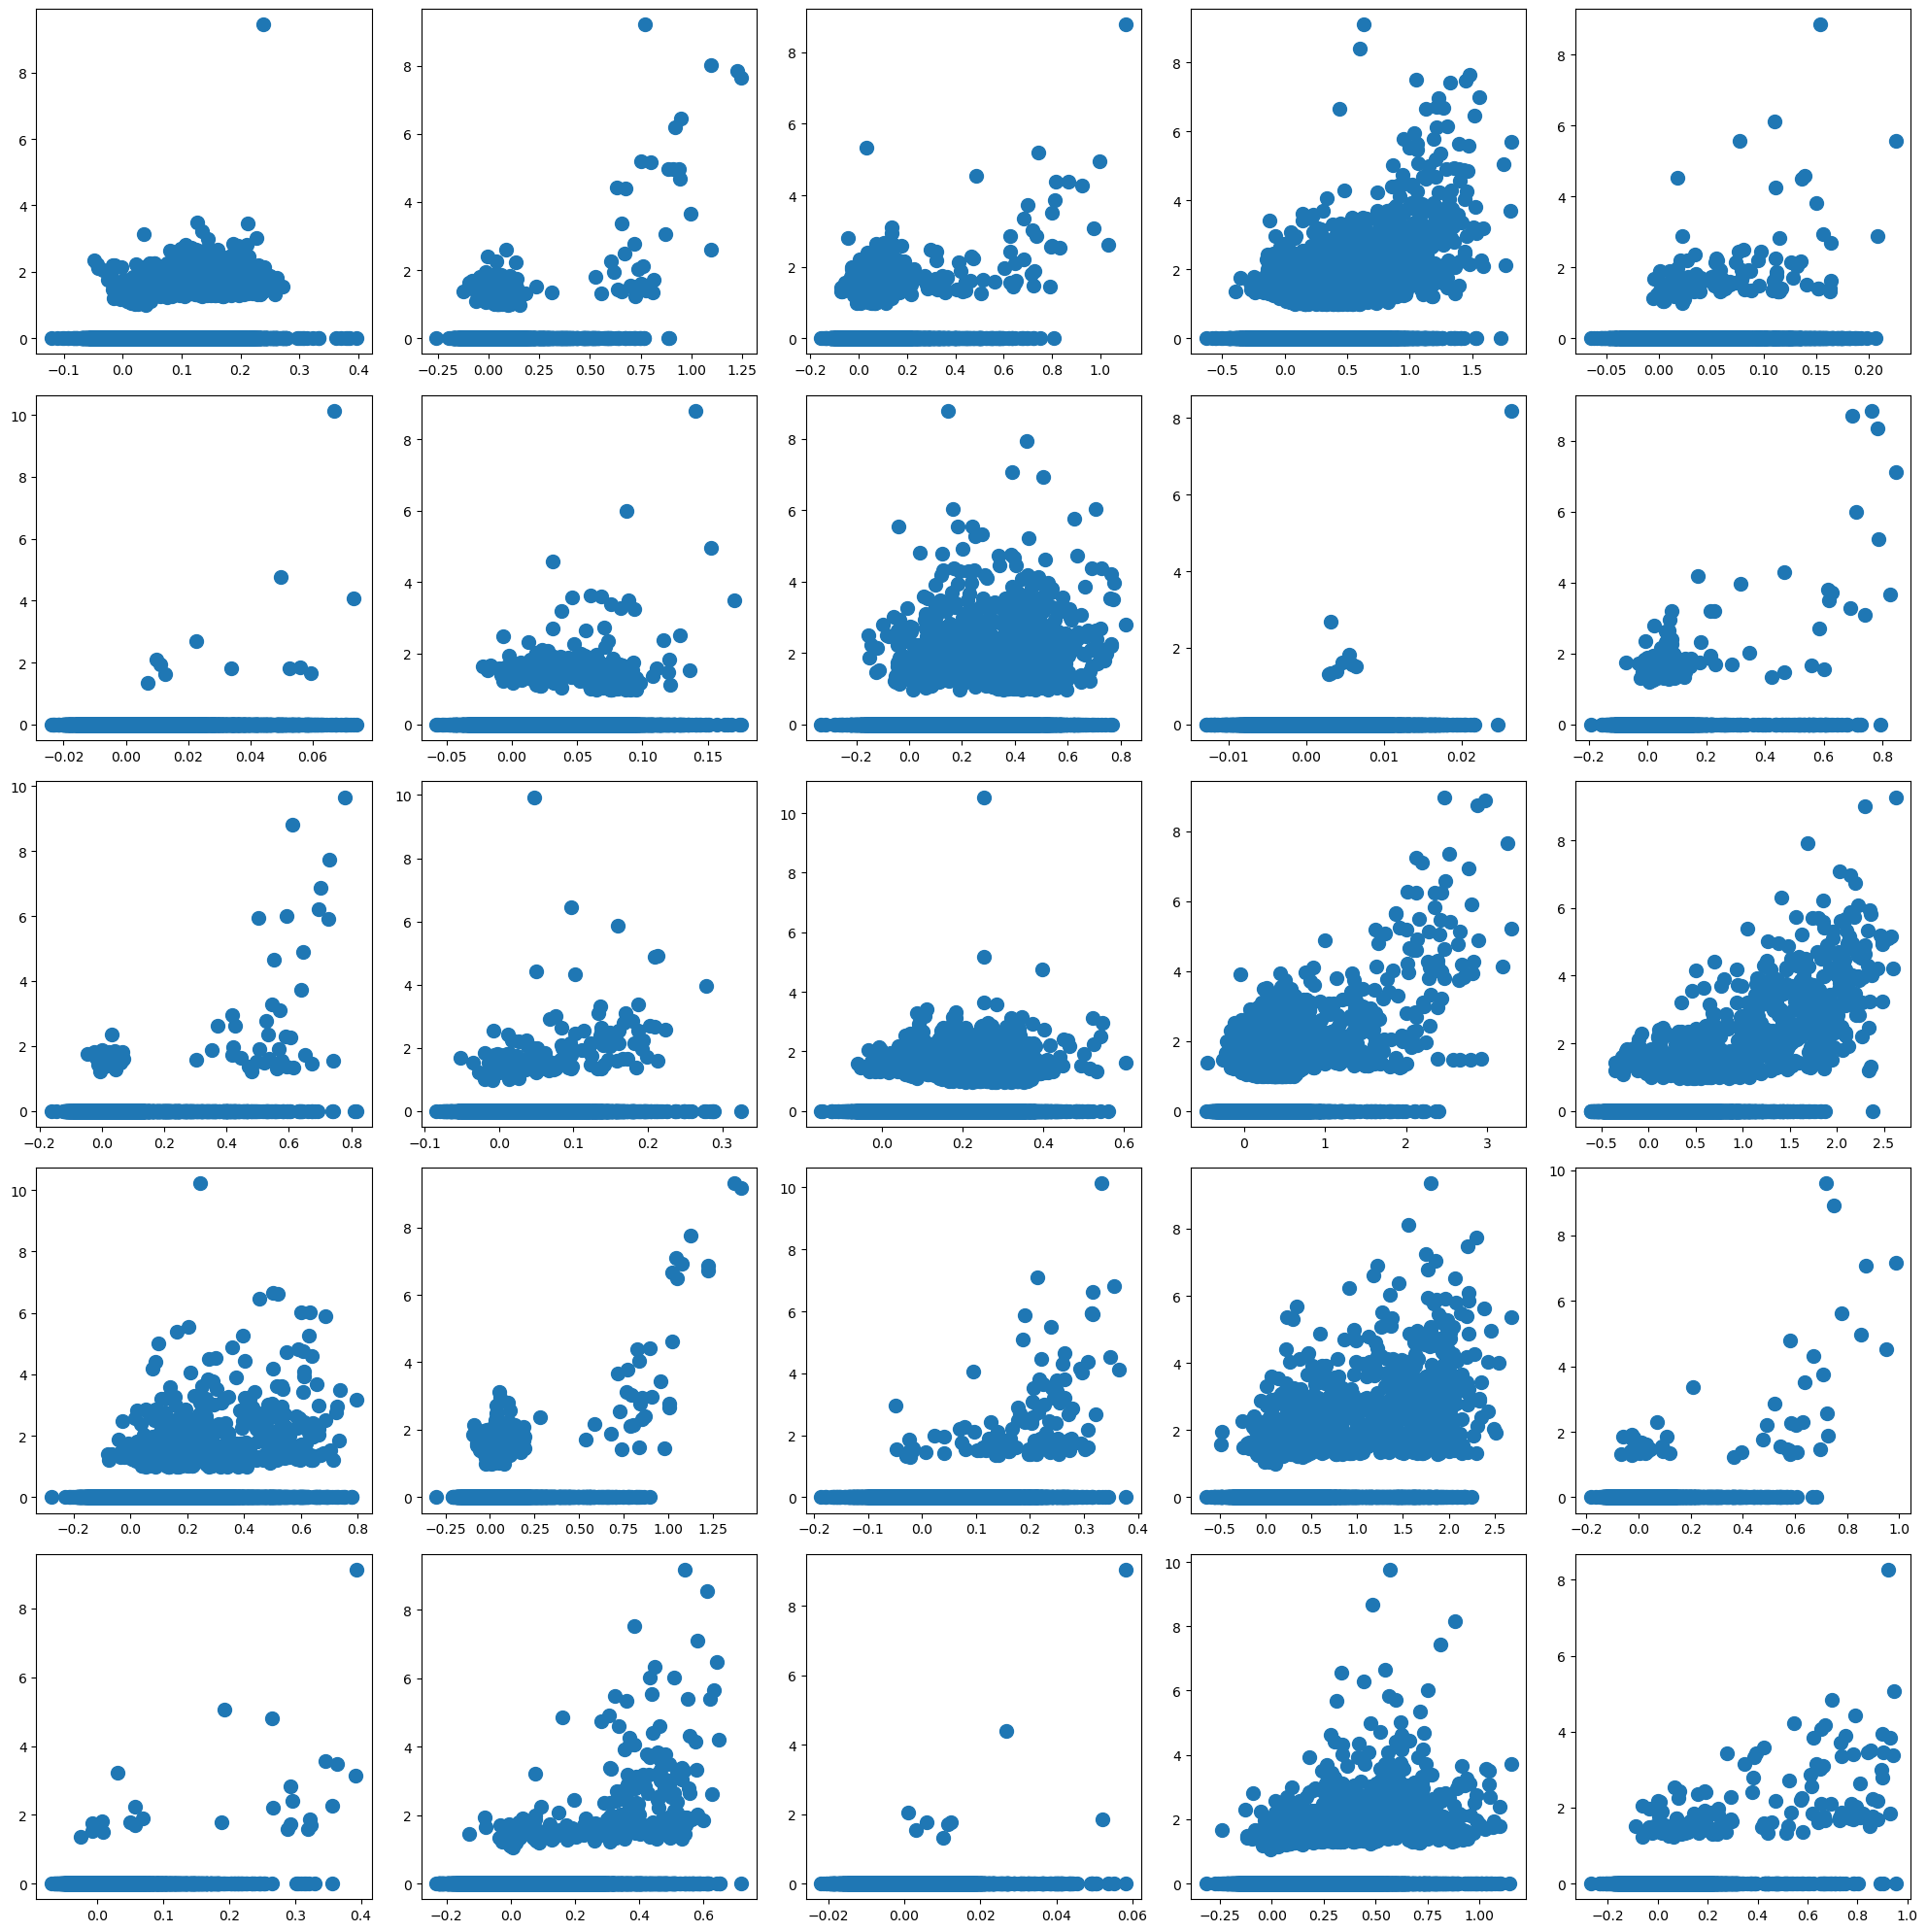

In [114]:
example_true = adata[:, example_gene_mask].X.toarray()
example_decoded = X_pca_dec_back[:, example_gene_mask]

n_genes = example_decoded.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

for i in range(n_genes):
    ax = axes[i]
    # ax.scatter(example_decoded[:, i], example_true[:, i], s=100)
    ax.scatter(np.asarray(example_decoded[:, i]).flatten(), np.asarray(example_true[:, i]).flatten(), s=100)
    # ax.set_title(example_gene[i].split("_Cycle")[-1])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


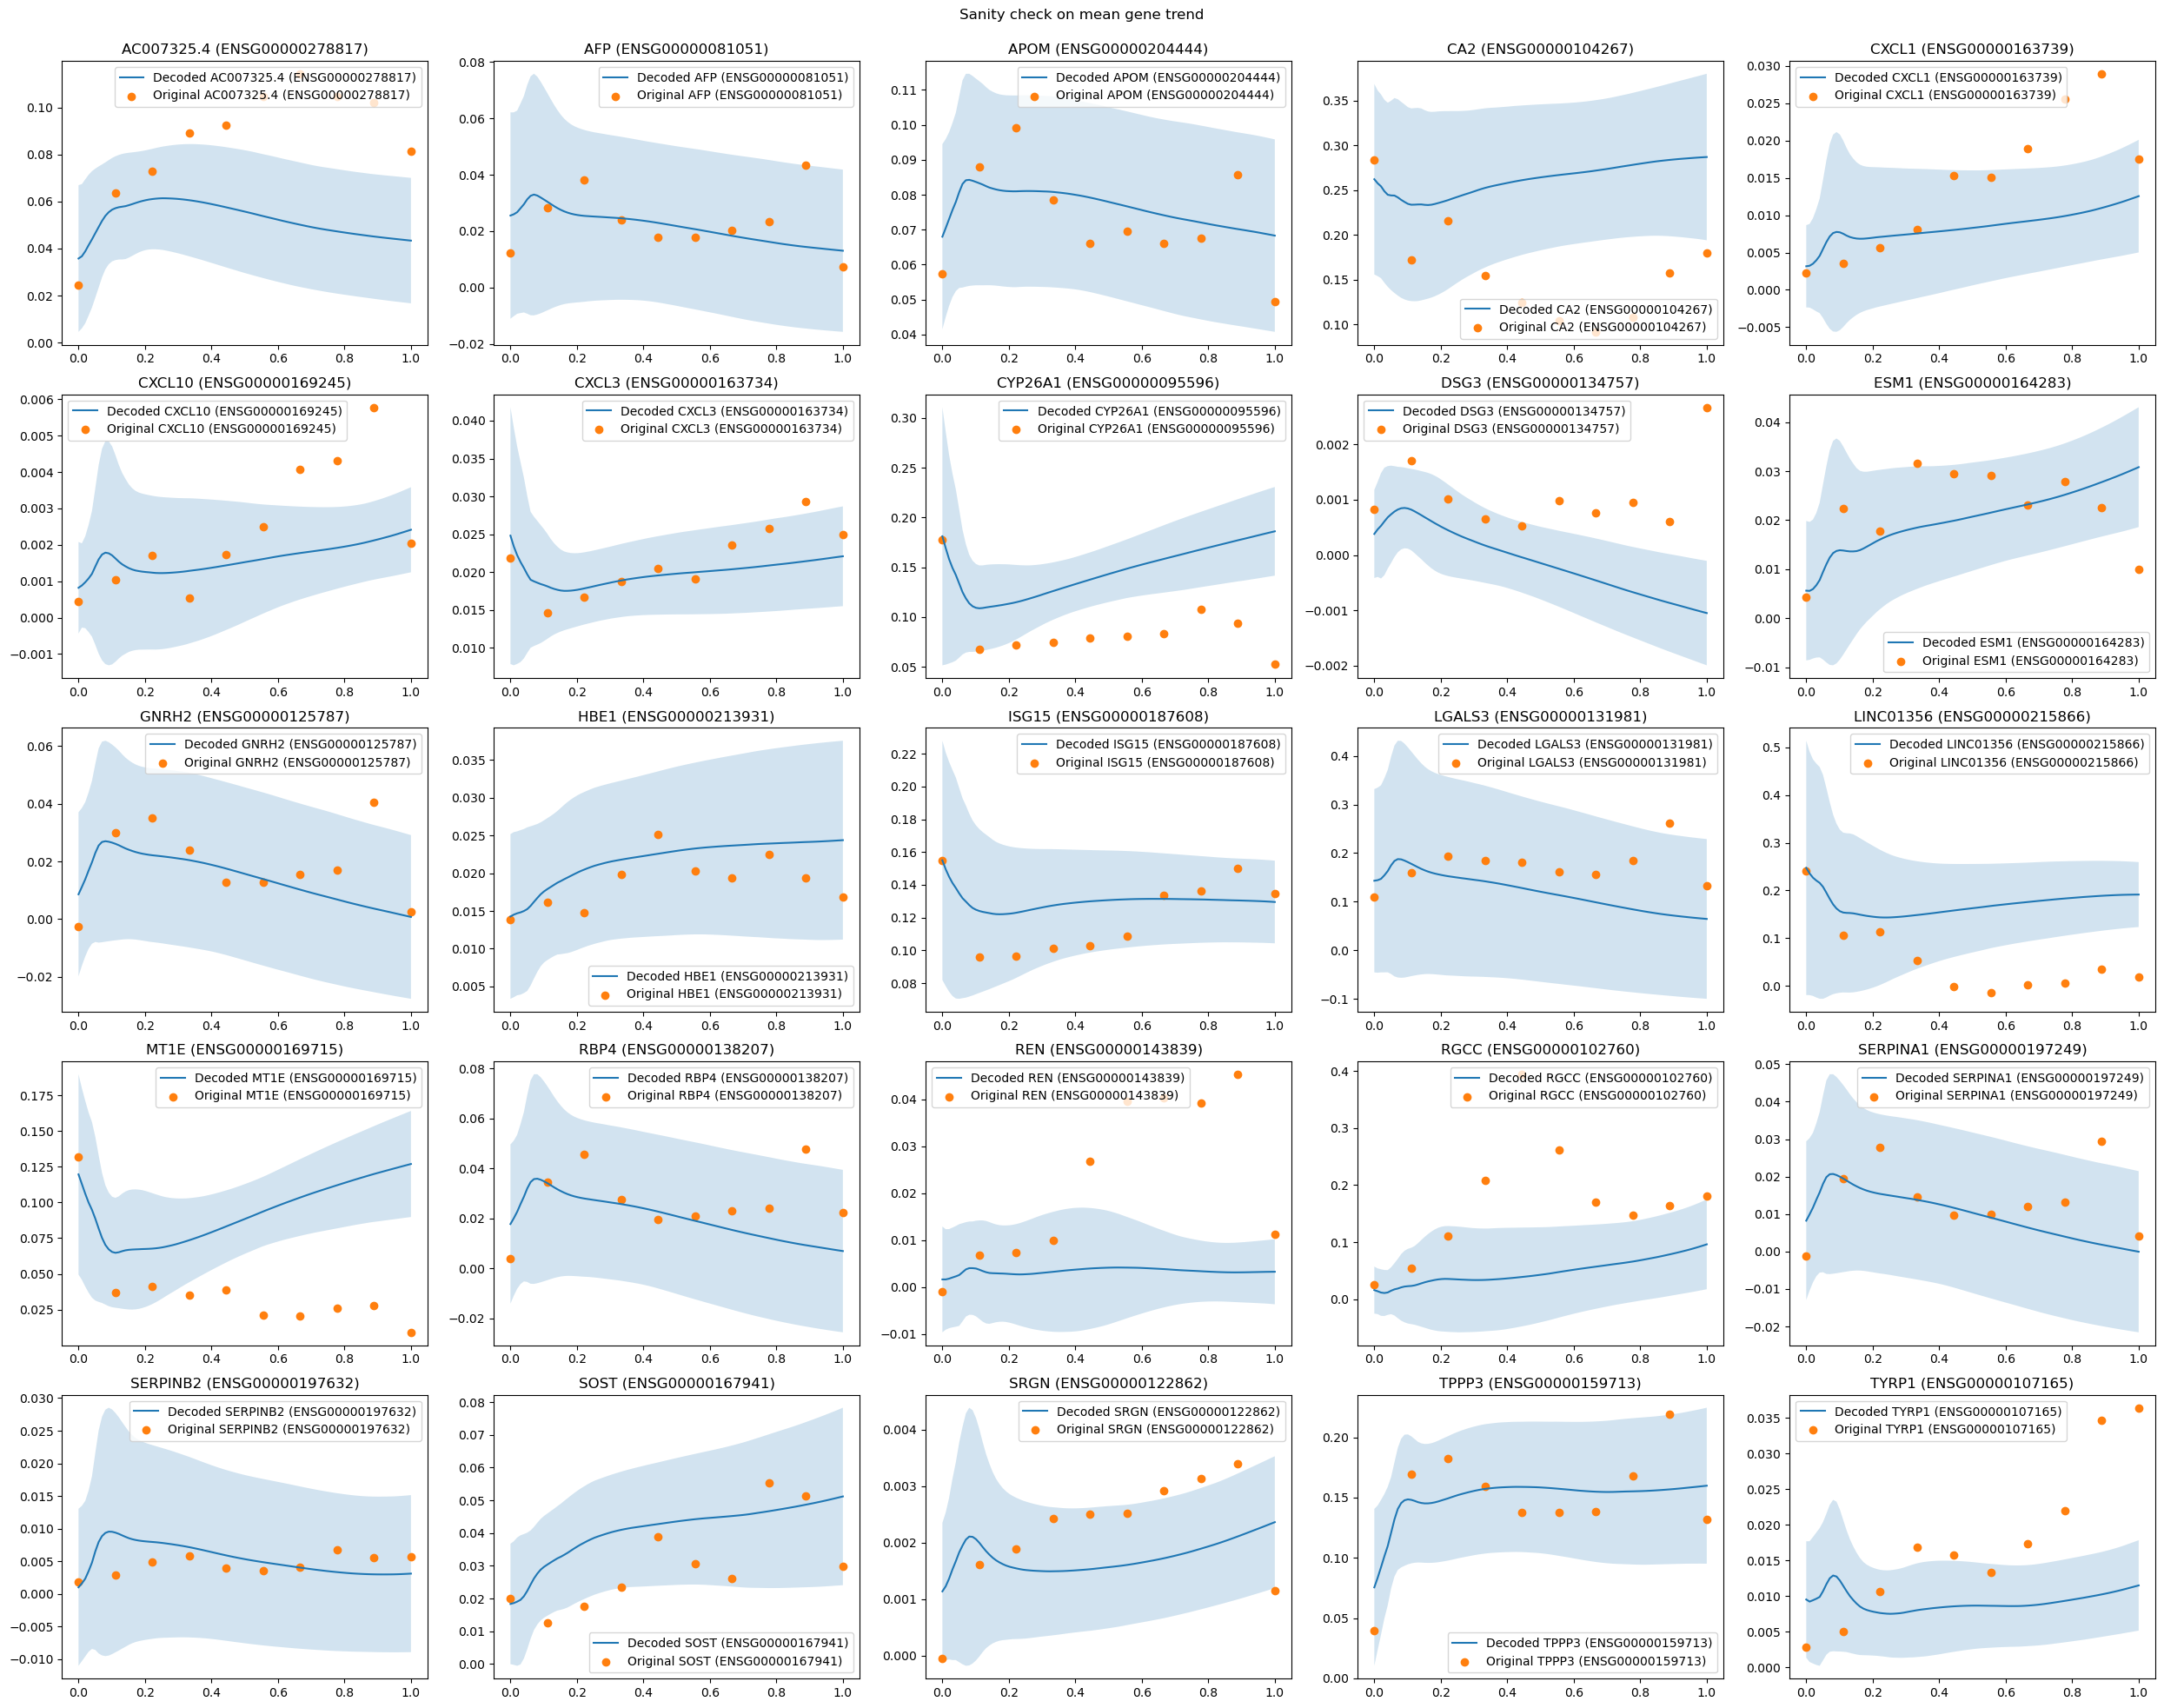

In [115]:
adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = traj_gene_sp[:, :, example_gene_mask]
decoded_example_gene_mean = decoded_example_gene.mean(axis=1)
decoded_example_gene_std = decoded_example_gene.std(axis=1)
x_time = np.linspace(0, 1, traj.shape[1])
x_time_data = adata_example_gene.obs['bin_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

# data_df = pd.DataFrame(adata_example_gene.X.toarray(), columns=example_gene, index=adata_example_gene.obs_names)
data_df = pd.DataFrame(X_pca_dec_back[:, example_gene_mask], columns=example_gene, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data

data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

n_genes = decoded_example_gene_mean.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_example_gene_mean[:,i], label=f'Decoded {example_gene[i].split("_Cycle")[-1]}')
    ax.fill_between(x_time, decoded_example_gene_mean[:,i] - decoded_example_gene_std[:,i], decoded_example_gene_mean[:,i] + decoded_example_gene_std[:,i], alpha=0.2)
    ax.scatter(data_mean.index, data_mean[example_gene[i]], label=f'Original {example_gene[i].split("_Cycle")[-1]}')
    # ax.fill_between(data_mean.index, data_mean[example_gene[i]] - data_std[example_gene[i]], data_mean[example_gene[i]] + data_std[example_gene[i]], alpha=0.2)
    ax.legend()
    ax.set_title(example_gene[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
# Add suptitle with padding
plt.subplots_adjust(top=0.95)  # Leave space at top
plt.suptitle('Sanity check on mean gene trend', y=0.98)  # Position suptitle in the space

plt.show()

In [116]:
import magic

In [117]:
magic_op = magic.MAGIC(random_state=42, n_jobs=-1)
magic_op.fit(adata.obsm['X_pca'])
X_magic = magic_op.transform(adata[:, example_gene_mask].X)

Running MAGIC on 17944 cells and 50 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 4.26 seconds.
  Calculating affinities...
  Calculated affinities in 4.21 seconds.
Calculated graph and diffusion operator in 8.48 seconds.
Calculating imputation...
Calculated imputation in 0.01 seconds.


/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


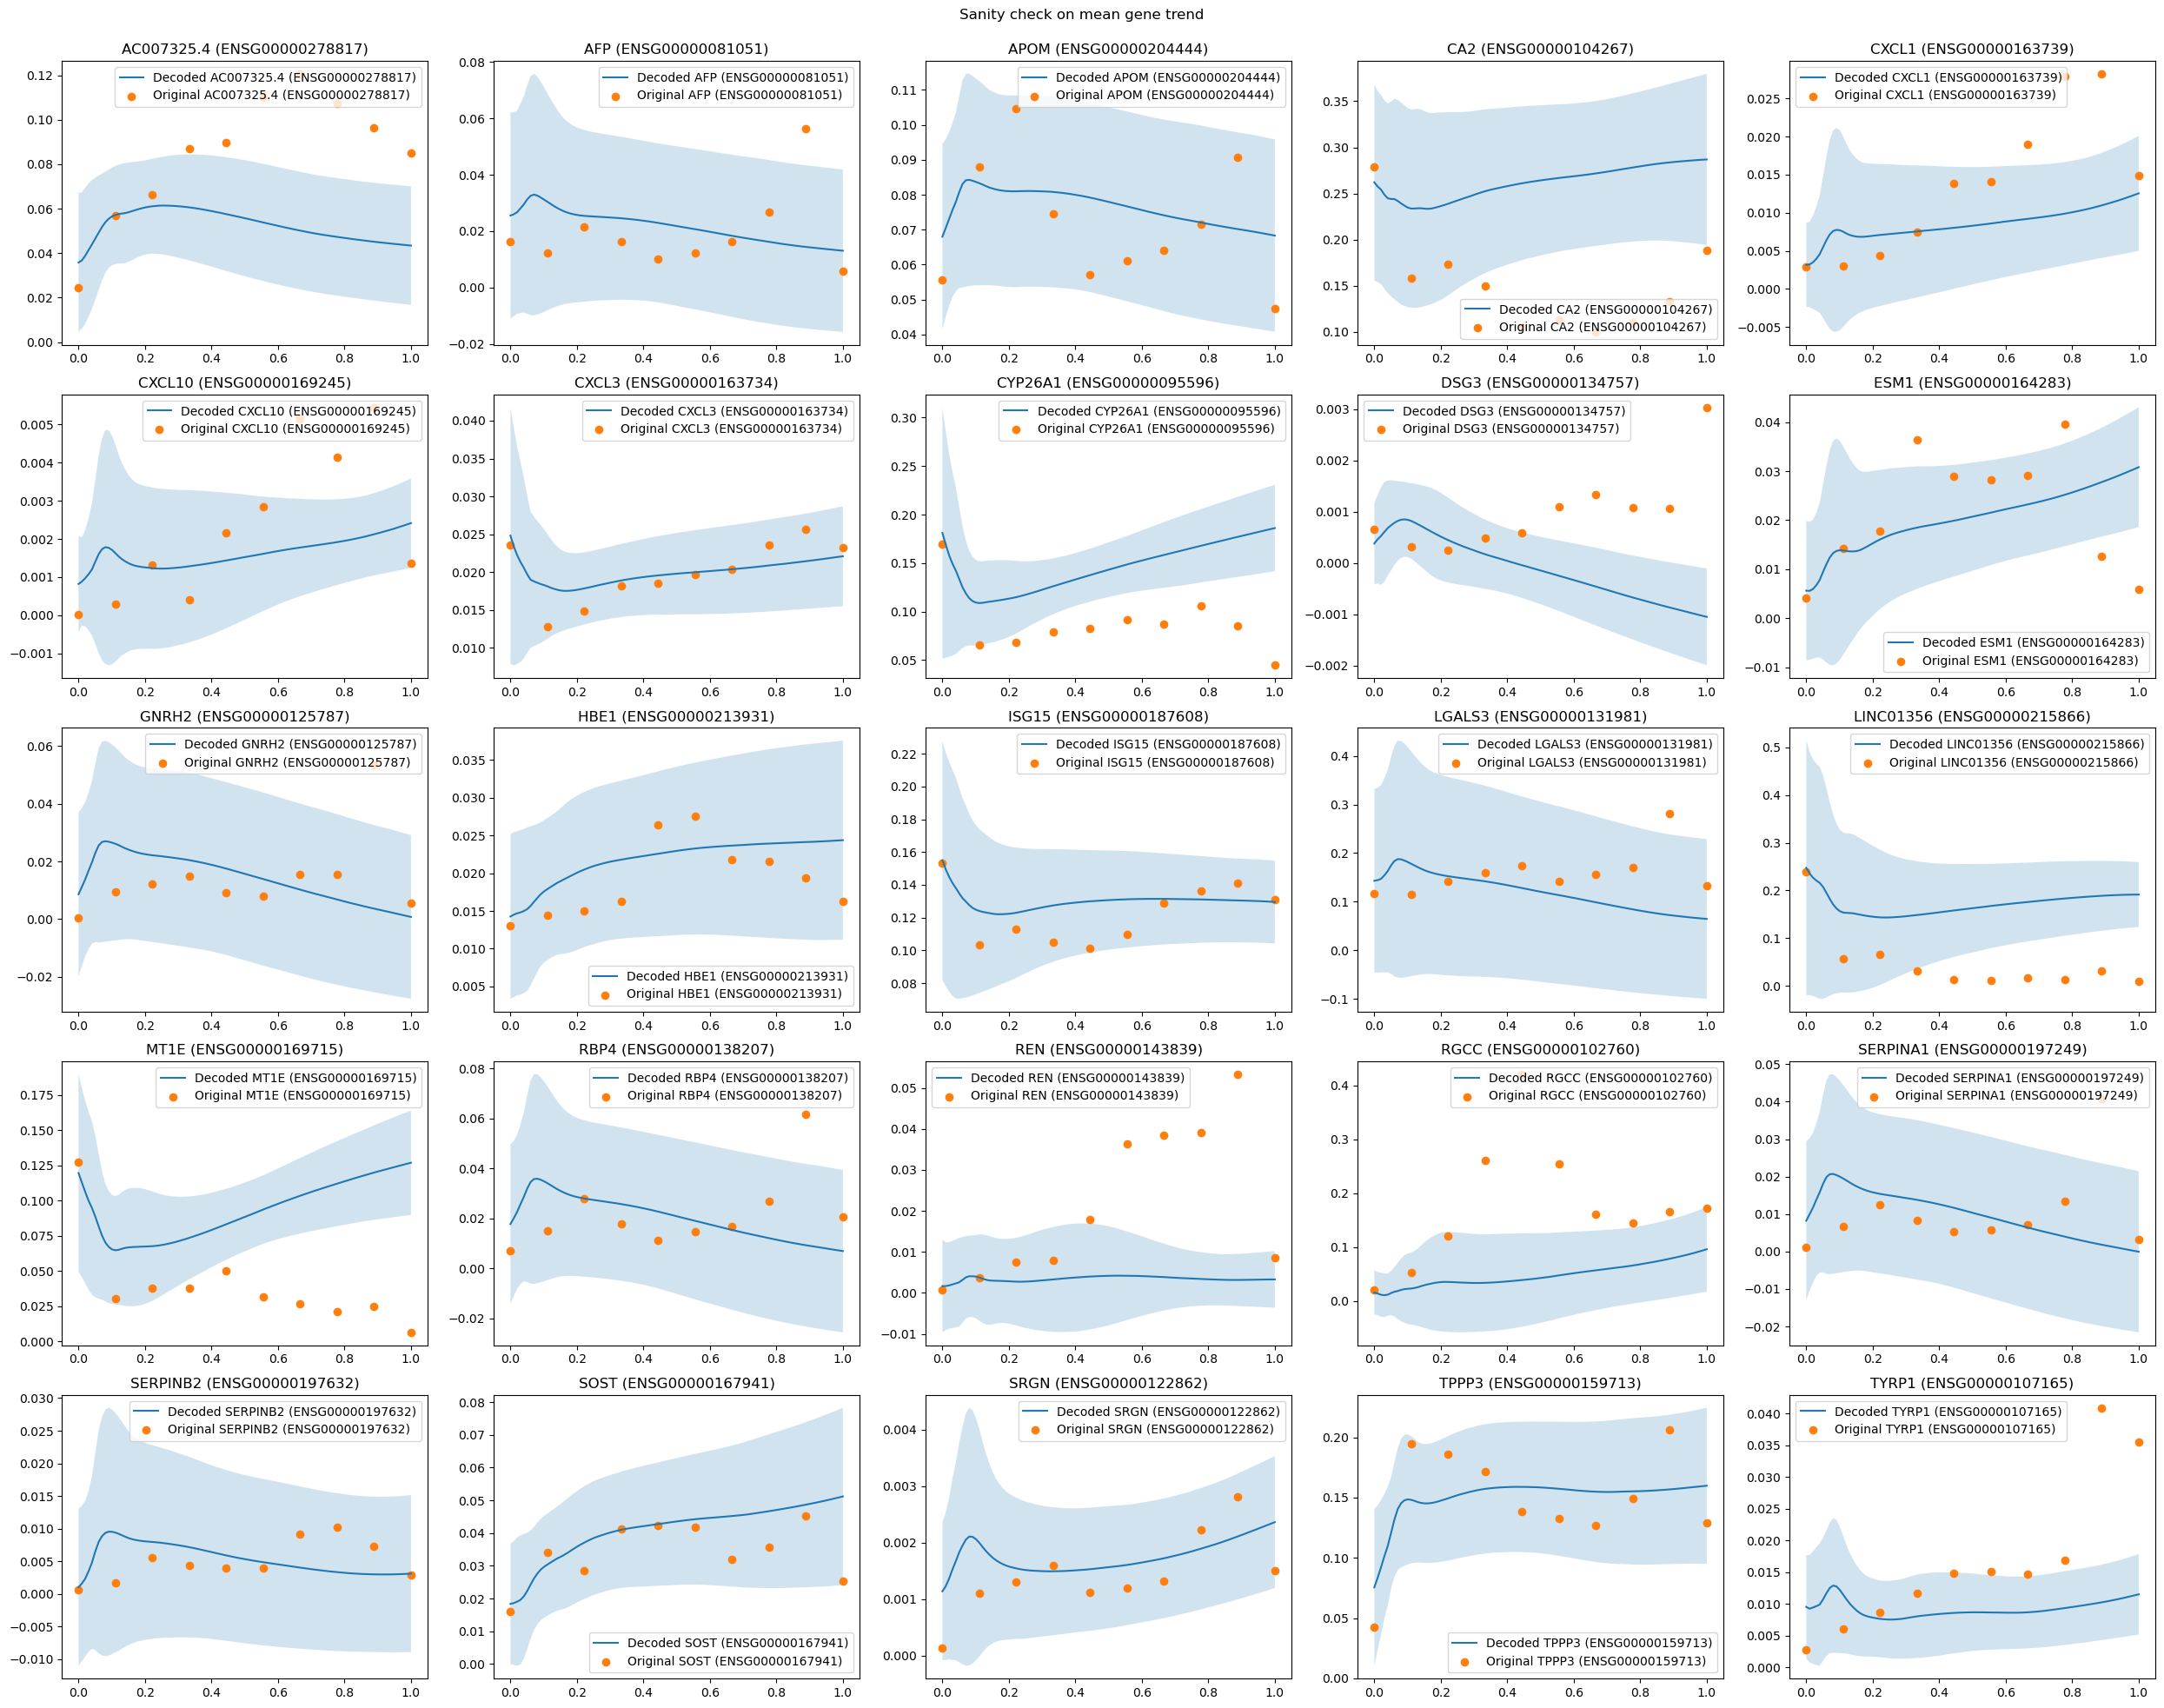

In [118]:
adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = traj_gene_sp[:, :, example_gene_mask]
decoded_example_gene_mean = decoded_example_gene.mean(axis=1)
decoded_example_gene_std = decoded_example_gene.std(axis=1)
x_time = np.linspace(0, 1, traj.shape[1])
x_time_data = adata_example_gene.obs['bin_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

data_df = pd.DataFrame(X_magic, columns=example_gene, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data

data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

n_genes = decoded_example_gene_mean.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_example_gene_mean[:,i], label=f'Decoded {example_gene[i]}')
    ax.fill_between(x_time, decoded_example_gene_mean[:,i] - decoded_example_gene_std[:,i], decoded_example_gene_mean[:,i] + decoded_example_gene_std[:,i], alpha=0.2)
    ax.scatter(data_mean.index, data_mean[example_gene[i]], label=f'Original {example_gene[i]}')
    # ax.fill_between(data_mean.index, data_mean[example_gene[i]] - data_std[example_gene[i]], data_mean[example_gene[i]] + data_std[example_gene[i]], alpha=0.2)
    ax.legend()
    ax.set_title(example_gene[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
# Add suptitle with padding
plt.subplots_adjust(top=0.95)  # Leave space at top
plt.suptitle('Sanity check on mean gene trend', y=0.98)  # Position suptitle in the space

plt.show()

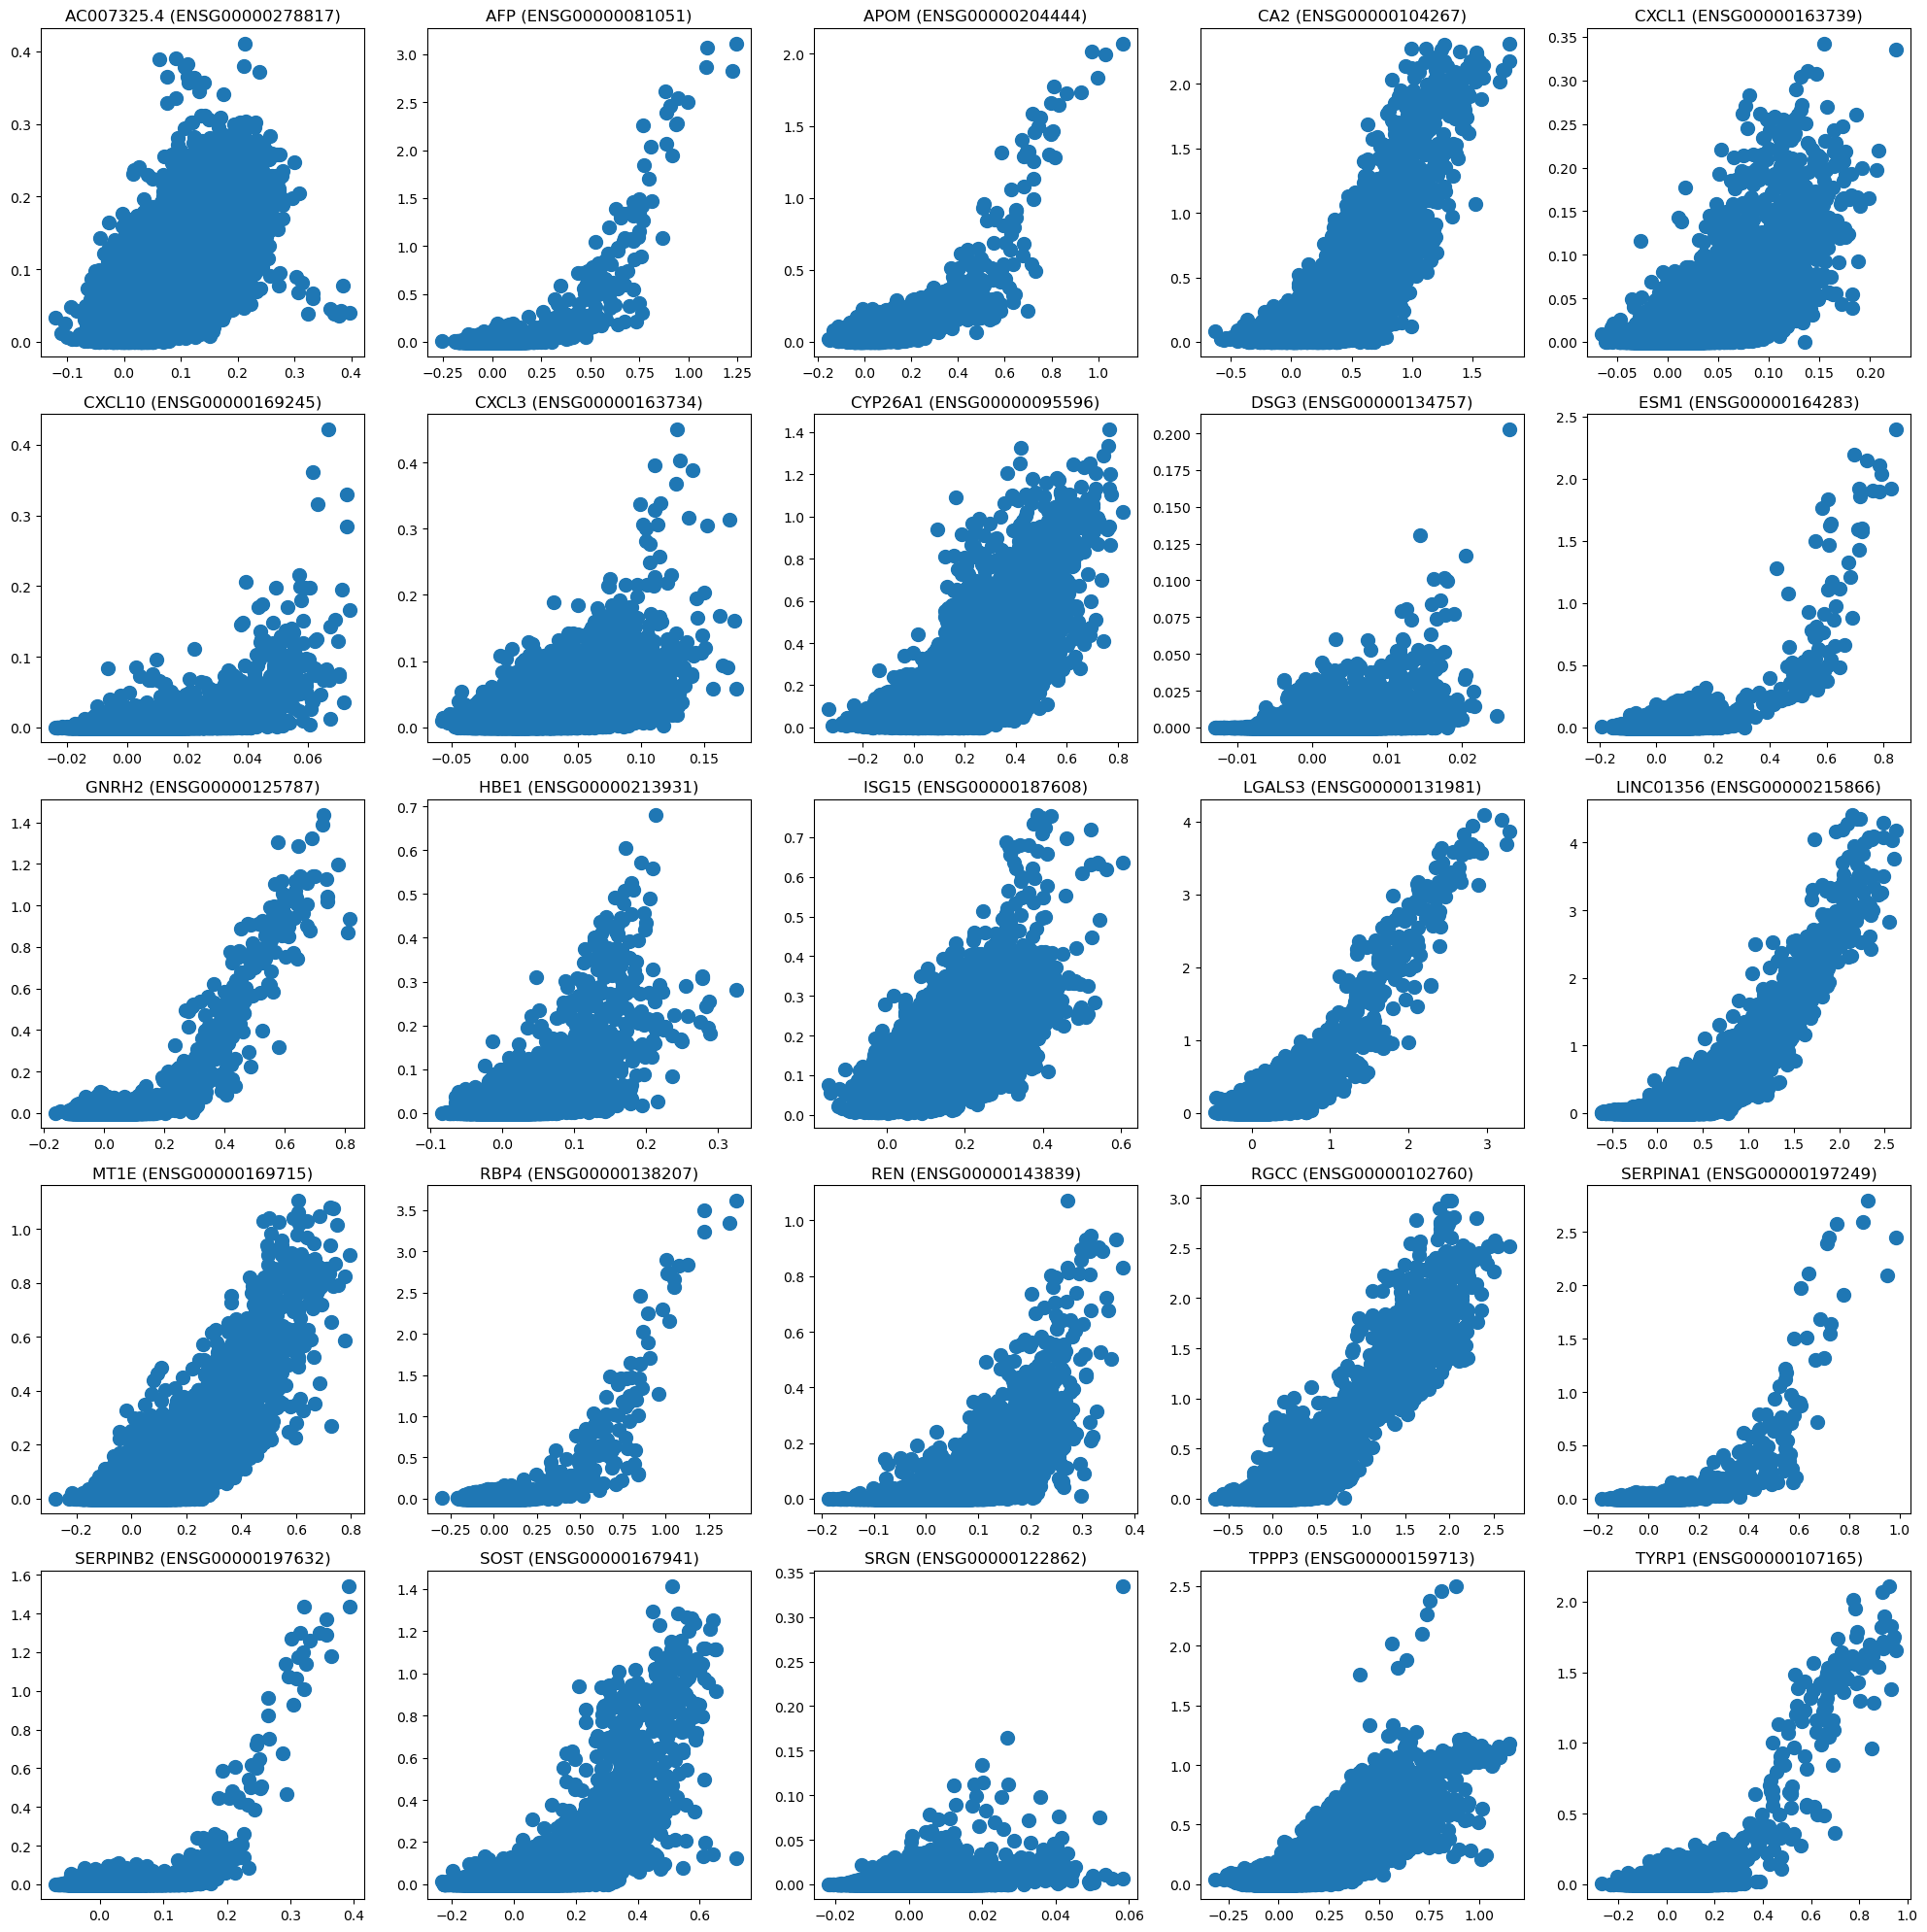

In [120]:
# example_true = adata[:, example_gene_mask].X.toarray()
example_true = X_magic
example_decoded = X_pca_dec_back[:, example_gene_mask]

n_genes = example_decoded.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

for i in range(n_genes):
    ax = axes[i]
    # ax.scatter(example_decoded[:, i], example_true[:, i], s=100)
    ax.scatter(np.asarray(example_decoded[:, i]).flatten(), 
           np.asarray(example_true[:, i]).flatten(), s=100)
    ax.set_title(example_gene[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()
